audio_recordings\recorded_audio.wav
Recording...
Recording started.
Audio saved as: audio_recordings\recorded_audio.wav
0.0033564607
Classification: Far
Processing audio file...
Could not understand audio
audio_recordings\recorded_audio.wav


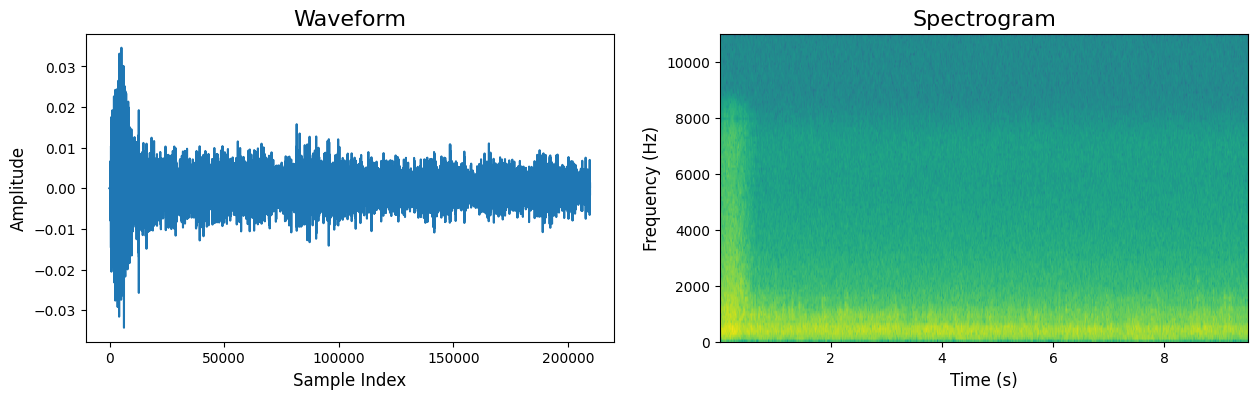

1/1 [==============================] - 0s 104ms/step
[1.3595262e-05 2.3999752e-05 6.4103951e-04 1.7177707e-01 1.4704694e-05
 3.4898808e-06 8.2708198e-01 4.1208372e-05 2.4339839e-04 1.5949675e-04]
Predicted Sound: gun_shot
Classification - Other Sound


In [24]:
import speech_recognition as sr
from pydub import AudioSegment
import sounddevice as sd
import numpy as np
import librosa
import os
from keras.models import load_model
import scipy.io.wavfile as wavfile

# Function to record audio and save as a WAV file
def record_audio_and_save(filename, duration=10, sample_rate=22050, threshold=0.01):
    print("Recording...")
    recording = False
    audio_frames = []

    def callback(indata, frames, time, status):
        if status:
            print(f"Error in audio recording: {status}")
            return
        volume_norm = np.linalg.norm(indata) * 10
        if volume_norm > threshold:
            nonlocal recording
            if not recording:
                print("Recording started.")
                recording = True
            audio_frames.append(indata.copy())
        else:
            if recording:
                print("Recording stopped.")
                return sd.CallbackStop

    with sd.InputStream(channels=1, samplerate=sample_rate, callback=callback):
        sd.sleep(int(duration * 1000))

    if len(audio_frames) > 0:
        audio = np.concatenate(audio_frames)
        # Save the audio as a WAV file
        wavfile.write(filename, sample_rate, audio)
        print(f"Audio saved as: {filename}")
    else:
        print("No audio recorded.")

# Function to convert WAV file to PCM WAV format
def convert_to_pcm_wav(input_file, output_file):
    sound = AudioSegment.from_file(input_file, format="wav")
    sound = sound.set_frame_rate(16000)  # Set frame rate to 16 kHz (required for Google Speech Recognition)
    sound = sound.set_sample_width(2)  # Set sample width to 16-bit (2 bytes)
    sound = sound.set_channels(1)  # Set channels to mono (1 channel)
    sound.export(output_file, format="wav")

# Function to recognize speech from a WAV file
def recognize_speech_from_file(file_path):
    recognizer = sr.Recognizer()

    # Convert to PCM WAV format
    pcm_wav_file = "converted_pcm.wav"
    convert_to_pcm_wav(file_path, pcm_wav_file)

    # Use the converted PCM WAV file as the audio source
    with sr.AudioFile(pcm_wav_file) as source:
        print("Processing audio file...")

        try:
            # Read the audio data from the file
            audio = recognizer.record(source)

            # Use Google Web Speech API to recognize the audio
            recognized_text = recognizer.recognize_google(audio)
            print("Speech in file:", recognized_text)
            return recognized_text.lower()  # Convert to lowercase for easier comparison

        except sr.UnknownValueError:
            print("Could not understand audio")
            return ""
        except sr.RequestError as e:
            print("Error fetching results; {0}".format(e))
            return ""

# Function to check for alert words
def check_for_alerts(text):
    alert_words = ["emergency", "help", "fire", "danger", "alert", "attention", "stop"]

    for word in alert_words:
        if word in text:
            return True

    return False

# Function to run sound recognition code
def run_sound_recognition(audioFile):

    print(audioFile)
    # Loading audio file
    waveform, sampleRate = librosa.load(audioFile)


    # Displaying audio
    #print(f"Class : {row['class']}\n")
    ipd.display(ipd.Audio(waveform, rate = sampleRate))

    # Displaying waveform
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(waveform)
    plt.title('Waveform', fontsize = 16)
    plt.xlabel('Sample Index', fontsize = 12)
    plt.ylabel('Amplitude', fontsize = 12)
    
    # Displaying spectrogram
    plt.subplot(1, 2, 2)
    plt.specgram(waveform, Fs = sampleRate)
    plt.title('Spectrogram', fontsize = 16)
    plt.xlabel('Time (s)', fontsize = 12)
    plt.ylabel('Frequency (Hz)', fontsize = 12)
    
    plt.show()
    
    def augmentData(waveform):
        # Applying pre-emphasis
        waveform = librosa.effects.preemphasis(waveform)
        
        # Time stretching
        if np.random.rand() < 0.5:
            rate = np.random.uniform(0.8, 1.2)
            waveform = librosa.effects.time_stretch(waveform, rate = rate)
    
        # Adding noise
        waveform += 0.01 * np.random.normal(size = waveform.shape)
    
        return waveform
    
    # Computing Mel-frequency cepstral coefficients
    def mfccExtract(file):
        # Loading audio file
        waveform, sampleRate = librosa.load(file)
        
        # Trim the first second
        waveform = waveform[int(sampleRate*2):]
        
        # waveform = augmentData(waveform)
        features = librosa.feature.mfcc(y = waveform, sr = sampleRate, n_mfcc = 64)
        return np.mean(features, axis = 1)
    

    
        # Constructing file path
    audioFile = os.path.join(audioPath)
        
        # Extracting features and appending them
    features = mfccExtract(audioFile)
    
    # Load the trained model
    model = load_model('audioalertrecog.h5')
    
    
    # Reshape the audio features to match the model input shape
    features =features.reshape(1, -1)
    
    
    # Make predictions
    predictions = model.predict(features)
    
    # Get the predicted class probabilities
    predicted_probs = predictions[0]
    print(predicted_probs)
    # Indices of "Alert Sound" classes
    alert_class_indices = [1, 2, 3, 4, 6, 7, 8]
    
    #for i in range(10):
    #    print(predicted_probs[i])
        
        # Get the actual predicted class name
    class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
    predicted_class_index = np.argmax(predictions)
    predicted_sound = class_names[predicted_class_index]
    
    print("Predicted Sound:", predicted_sound)

    
    # Check if predicted class is one of the "Alert Sound" classes
    if any(predicted_probs[i] > 0.90 for i in alert_class_indices):
        predicted_class_name = "Alert Sound"
        return predicted_class_name
    else:
        # Check if no predicted class exceeds a certain threshold
        if all(prob < 0.3 for prob in predicted_probs):
            predicted_class_name = "No Predicted Audio"
            return predicted_class_name
        else:
            predicted_class_name = "Other Sound"
            return predicted_class_name
    

    




# Main function
def main():
    # Specify the folder path to save the audio file
    folder_path = "audio_recordings"

    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Filename for the recorded audio
    filename = os.path.join(folder_path, "recorded_audio.wav")
    print(filename)
    # Record audio for 10 seconds and save as a WAV file
    record_audio_and_save(filename, duration=10, sample_rate=22050, threshold=0.01)

    # The distance calculator
    sample_rate, signal_data = wavfile.read('audio_recordings/recorded_audio.wav')

    # Calculate root mean square (RMS) energy as a feature
    rms_energy = np.sqrt(np.mean(signal_data**2))
    print(rms_energy)

    # Example threshold to classify as near or far
    threshold = 0.035 # Adjust as needed based on your data and requirements

    # Classify based on threshold
    classification = "Near" if rms_energy >= threshold else "Far"

    print("Classification:", classification)




    # Run speech recognition on the recorded audio
    text = recognize_speech_from_file(filename)

    # Check for alert words in the speech recognition output
    if check_for_alerts(text):
        print("SPEECH ALERT GENERATED:", text)
        return  # Exit the program

    # If no alert words found, run sound recognition
    sound_result = run_sound_recognition(filename)

    if sound_result == "Alert Sound":
        print("SOUND ALERT GENERATED: Classification -", sound_result)
    else:
        print("Classification -", sound_result)

# Run the main function
if __name__ == "__main__":
    main()
